In [1]:
# import matplotlib.pyplot as plt
import numpy as np

In [4]:
# a = np.random.randn(256*256)
# print(a.max(), a.min())

4.370321864074964 -4.627021488629094


In [6]:
# np.histogram(a)

(array([   12,   131,  1525,  8288, 19453, 21670, 11261,  2856,   320,
           20]),
 array([-4.62702149, -3.72728715, -2.82755282, -1.92781848, -1.02808415,
        -0.12834981,  0.77138452,  1.67111886,  2.57085319,  3.47058753,
         4.37032186]))

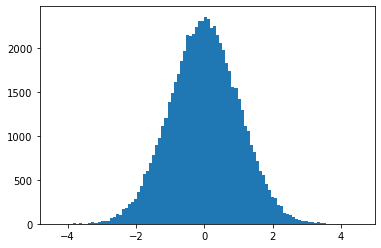

In [33]:
# raw_hist = plt.hist(a, bins=100)

In [3]:
def kl_divergence(p_dist, q_dist):
#     assert len(p_dist) == len(q_dist)
#     print(np.sum(p_dist), np.sum(q_dist))
    
#     if not (abs(np.sum(p_dist) - 1) < 0.0001):
#         print(p_dist)
#         assert False
        
#     if not (abs(np.sum(q_dist) - 1) < 0.0001):
#         print(q_dist)
#         assert False
        
    return np.sum([ (p_dist[i] * np.log(p_dist[i] / q_dist[i])) for i in range(len(p_dist)) ])

In [5]:
p_hist = np.histogram(np.random.randn(256*256))
p_dist = p_hist[0] / sum(p_hist[0])

q_hist = np.histogram(np.random.randn(256*256))
q_dist = q_hist[0] / sum(q_hist[0])

kl_divergence(p_dist, q_dist)

0.06270086231929767

In [7]:
def quantize_and_expand(raw_counts, num_quant_bins):
    num_raw_bins_per_quant_bin = len(raw_counts) // num_quant_bins
    num_quant_bins_1_extra = len(raw_counts) % num_quant_bins
    
    q_dist = []
    raw_idx_high = 0
    for i in range(num_quant_bins):
        raw_idx_low = raw_idx_high
        raw_idx_high = raw_idx_low + num_raw_bins_per_quant_bin + (i < num_quant_bins_1_extra)
        quant_counts = np.sum(raw_counts[raw_idx_low:raw_idx_high])
#         num_zeros = 0
#         for j in range(raw_idx_low, raw_idx_high):
#             if raw_counts[j] == 0:
#                 num_zeros += 1

        # do not retain zero
        for j in range(raw_idx_low, raw_idx_high):
#             if raw_counts[j] != 0: 
            q_dist.append(quant_counts / (raw_idx_high - raw_idx_low))
#             else:
#                 q_dist.append(0)

    q_dist = q_dist / np.sum(q_dist)
            
    return q_dist

In [8]:
raw_counts = [1, 0, 2, 3, 5, 3, 1, 7]
num_quant_bins = 2
print(quantize_and_expand(raw_counts, num_quant_bins))
raw_dist = np.array(raw_counts)/sum(raw_counts)
num_quant_bins = 2
print(quantize_and_expand(raw_dist, num_quant_bins))

[0.06818182 0.06818182 0.06818182 0.06818182 0.18181818 0.18181818
 0.18181818 0.18181818]
[0.06818182 0.06818182 0.06818182 0.06818182 0.18181818 0.18181818
 0.18181818 0.18181818]


In [15]:
import copy

def kl_quantization(raw_hist, num_quant_bins):
    raw_counts, raw_bins = raw_hist[0], raw_hist[1]
    min_kl_div = np.inf
    min_kl_div_low_bin = None
    min_kl_div_high_bin = None
    
    min_val = None
    max_val = None
    
    total_sum = np.sum(raw_counts)
    min_outlier_count = 0
    for i in range(len(raw_counts) - num_quant_bins):
        print(i)
        min_val = raw_bins[i]
        if i > 0:
            min_outlier_count += raw_counts[i]
        
        max_outlier_count = np.sum(raw_counts[i+num_quant_bins:len(raw_counts)])
        for j in range(i+num_quant_bins, len(raw_counts)):
            max_val = raw_bins[j]
            if j > i+num_quant_bins:
                max_outlier_count -= raw_counts[j-1]
            
            p_dist = copy.copy(raw_counts[i:j])
            
            p_dist[0] += min_outlier_count
            p_dist[-1] += max_outlier_count
            p_dist = np.array(p_dist) / np.sum(p_dist)
            
            q_dist = quantize_and_expand(raw_counts[i:j], num_quant_bins)
                
            
            kl_div = kl_divergence(p_dist, q_dist)
            if (kl_div < min_kl_div):
                min_kl_div = kl_div
                min_kl_div_low_bin = min_val
                min_kl_div_high_bin = max_val
                
    return min_kl_div_low_bin, min_kl_div_high_bin, min_kl_div

In [23]:
# raw_arr = np.random.randn(256*256)
raw_arr = [i for i in range(500)]
raw_hist = np.histogram(raw_arr, bins=256)
min_kl_div_low_bin, min_kl_div_high_bin, min_kl_div = kl_quantization(raw_hist, 128)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127


In [35]:
scale = (min_kl_div_high_bin - min_kl_div_low_bin) / (255)
zero_point = int(-128 - min_kl_div_low_bin / scale)
scale, zero_point

(1.94921875, -128)

In [42]:
import torch
dtype = torch.qint8
tensor = torch.tensor(raw_arr).float()
q_t = torch.quantize_per_tensor(tensor, scale, zero_point, dtype)
dq_t = q_t.dequantize()

In [46]:
diff = 0
for i in range(len(raw_arr)):
    print(abs(raw_arr[i] - dq_t[i]))
    diff += abs(raw_arr[i] - dq_t[i])
print(diff)

tensor(0.)
tensor(0.9492)
tensor(0.0508)
tensor(0.8984)
tensor(0.1016)
tensor(0.8477)
tensor(0.1523)
tensor(0.7969)
tensor(0.2031)
tensor(0.7461)
tensor(0.2539)
tensor(0.6953)
tensor(0.3047)
tensor(0.6445)
tensor(0.3555)
tensor(0.5938)
tensor(0.4062)
tensor(0.5430)
tensor(0.4570)
tensor(0.4922)
tensor(0.5078)
tensor(0.4414)
tensor(0.5586)
tensor(0.3906)
tensor(0.6094)
tensor(0.3398)
tensor(0.6602)
tensor(0.2891)
tensor(0.7109)
tensor(0.2383)
tensor(0.7617)
tensor(0.1875)
tensor(0.8125)
tensor(0.1367)
tensor(0.8633)
tensor(0.0859)
tensor(0.9141)
tensor(0.0352)
tensor(0.9648)
tensor(0.0156)
tensor(0.9336)
tensor(0.0664)
tensor(0.8828)
tensor(0.1172)
tensor(0.8320)
tensor(0.1680)
tensor(0.7812)
tensor(0.2188)
tensor(0.7305)
tensor(0.2695)
tensor(0.6797)
tensor(0.3203)
tensor(0.6289)
tensor(0.3711)
tensor(0.5781)
tensor(0.4219)
tensor(0.5273)
tensor(0.4727)
tensor(0.4766)
tensor(0.5234)
tensor(0.4258)
tensor(0.5742)
tensor(0.3750)
tensor(0.6250)
tensor(0.3242)
tensor(0.6758)
tensor(0.2734)

In [166]:
raw_arr.min(), raw_arr.max()

(-4.4599517400129365, 4.533521057991189)

In [ ]:
plt.hist(raw_arr)